In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk, emoji
nltk.download('stopwords', quiet=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
TRAIN_TXT = "/content/train.txt"
VAL_TXT   = "/content/val.txt"
TEST_TXT  = "/content/test.txt"

import pandas as pd

def read_split(path):
    df = pd.read_csv(path, sep=None, engine="python", header=None, names=["text","label"])
    df["text"]  = df["text"].astype(str).str.strip().str.strip('"').str.strip()
    df["label"] = df["label"].astype(str).str.strip().str.strip('"').str.strip()
    return df

train_df = read_split(TRAIN_TXT)
val_df   = read_split(VAL_TXT)
test_df  = read_split(TEST_TXT)

print("Train:", train_df.shape, "\nVal  :", val_df.shape, "\nTest :", test_df.shape)

Train: (16000, 2) 
Val  : (2000, 2) 
Test : (2000, 2)


In [8]:
train_df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [11]:
import re, emoji
from nltk.corpus import stopwords
STOP_EN = set(stopwords.words("english"))

def clean_tweet(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.strip()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"\brt\b", " ", s, flags=re.IGNORECASE)
    s = re.sub(r"#(\w+)", r"\1", s)
    s = emoji.demojize(s).replace(":", " ").replace("_", " ")
    s = re.sub(r"[^a-zA-Z0-9\s!?.,']", " ", s).lower()
    s = re.sub(r"(.)\1{2,}", r"\1\1", s)
    s = re.sub(r"\s+", " ", s).strip()
    toks = [t for t in s.split() if (t not in STOP_EN or t in {"no","not","nor"})]
    return " ".join(toks)

for df_ in (train_df, val_df, test_df):
    df_["text_clean"] = df_["text"].astype(str).map(clean_tweet)

In [12]:
train_df[["text","text_clean","label"]].head(8)

,text,text_clean,label
0,i didnt feel humiliated,didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing a minute to post i feel greedy wrong,im grabbing minute post feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,ever feeling nostalgic fireplace know still pr...,love
4,i am feeling grouchy,feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,ive feeling little burdened lately wasnt sure,sadness
6,ive been taking or milligrams or times recomme...,ive taking milligrams times recommended amount...,surprise
7,i feel as confused about life as a teenager or...,feel confused life teenager jaded year old man,fear


In [14]:
def describe_split(name, df_):
    print(f"{name}:", df_.shape)
    print(df_["label"].value_counts(), "\n")

describe_split("Train", train_df)
describe_split("Val",   val_df)
describe_split("Test",  test_df)

Train: (16000, 3)
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64 

Val: (2000, 3)
label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64 

Test: (2000, 3)
label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64 



In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pickle

le = LabelEncoder()
y_tr = le.fit_transform(train_df["label"])
y_va = le.transform(val_df["label"])
y_te = le.transform(test_df["label"])

#TF-IDF Fitting
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", ngram_range=(1,2), min_df=2, max_df=0.9)
X_tr = tfidf.fit_transform(train_df["text_clean"])
X_va = tfidf.transform(val_df["text_clean"])
X_te = tfidf.transform(test_df["text_clean"])

#LinearSVC Training
svc = LinearSVC()
svc.fit(X_tr, y_tr)

#Validation
va_pred = svc.predict(X_va)
print("VALID acc:", accuracy_score(y_va, va_pred))
print(classification_report(y_va, va_pred, target_names=le.classes_))

VALID acc: 0.9045
              precision    recall  f1-score   support

       anger       0.93      0.89      0.91       275
        fear       0.86      0.82      0.84       212
         joy       0.92      0.94      0.93       704
        love       0.84      0.83      0.83       178
     sadness       0.93      0.95      0.94       550
    surprise       0.78      0.77      0.78        81

    accuracy                           0.90      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.90      0.90      0.90      2000



TEST acc: 0.901
              precision    recall  f1-score   support

       anger       0.90      0.88      0.89       275
        fear       0.89      0.87      0.88       224
         joy       0.91      0.94      0.92       695
        love       0.80      0.79      0.79       159
     sadness       0.93      0.94      0.93       581
    surprise       0.77      0.65      0.70        66

    accuracy                           0.90      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



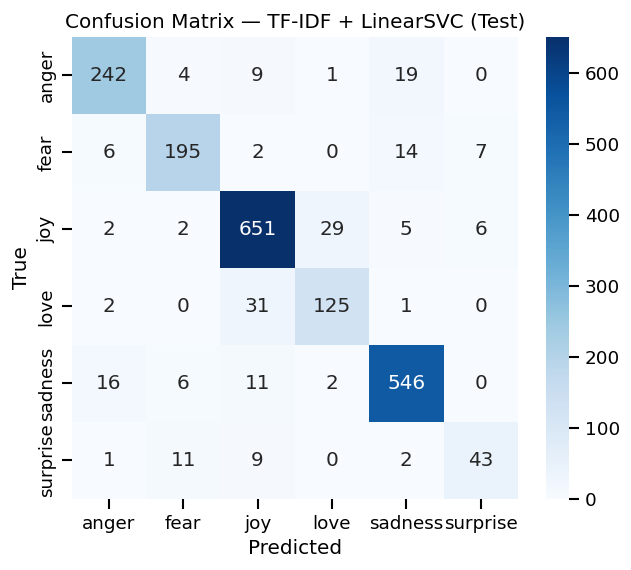

In [17]:
#Confusion Matrix
te_pred = svc.predict(X_te)
print("TEST acc:", accuracy_score(y_te, te_pred))
print(classification_report(y_te, te_pred, target_names=le.classes_))

cm = confusion_matrix(y_te, te_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — TF-IDF + LinearSVC (Test)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

In [18]:
import pickle, os
pickle.dump(tfidf, open("/content/tfidf.pkl","wb"))
pickle.dump(le,    open("/content/label_encoder.pkl","wb"))
pickle.dump(svc,   open("/content/svc.pkl","wb"))
print("Saved → /content/tfidf.pkl, /content/label_encoder.pkl, /content/svc.pkl")

Saved → /content/tfidf.pkl, /content/label_encoder.pkl, /content/svc.pkl


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tok = Tokenizer(oov_token="<unk>")
tok.fit_on_texts(train_df["text_clean"])
MAX_LEN = 48

Xtr_seq = pad_sequences(tok.texts_to_sequences(train_df["text_clean"]), maxlen=MAX_LEN, padding="post")
Xva_seq = pad_sequences(tok.texts_to_sequences(val_df["text_clean"]),   maxlen=MAX_LEN, padding="post")
Xte_seq = pad_sequences(tok.texts_to_sequences(test_df["text_clean"]),  maxlen=MAX_LEN, padding="post")

num_classes = len(le.classes_)
model = models.Sequential([
    layers.Embedding(input_dim=len(tok.word_index)+1, output_dim=128, mask_zero=True, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.25),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.25),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
hist = model.fit(Xtr_seq, le.transform(train_df["label"]),
                 validation_data=(Xva_seq, le.transform(val_df["label"])),
                 epochs=10, batch_size=128, callbacks=[es], verbose=1)

te_pred_nn = model.predict(Xte_seq).argmax(axis=1)
print("BiLSTM TEST acc:", accuracy_score(le.transform(test_df["label"]), te_pred_nn))
print(classification_report(le.transform(test_df["label"]), te_pred_nn, target_names=le.classes_))

model.save("/content/bilstm_emotion.h5")
pickle.dump(tok, open("/content/tokenizer.pkl","wb"))
print("Saved → /content/bilstm_emotion.h5, /content/tokenizer.pkl")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 724ms/step - accuracy: 0.3875 - loss: 1.4938 - val_accuracy: 0.7800 - val_loss: 0.6622
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 673ms/step - accuracy: 0.8591 - loss: 0.4096 - val_accuracy: 0.8600 - val_loss: 0.4006
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 677ms/step - accuracy: 0.9421 - loss: 0.1651 - val_accuracy: 0.8940 - val_loss: 0.3327
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 661ms/step - accuracy: 0.9729 - loss: 0.0805 - val_accuracy: 0.9040 - val_loss: 0.3436
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 678ms/step - accuracy: 0.9831 - loss: 0.0489 - val_accuracy: 0.9075 - val_loss: 0.3287
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 671ms/step - accuracy: 0.9868 - loss: 0.0372 - val_accuracy: 0.9075 - val_loss: 0.3393
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 144s 683ms/step - accuracy: 0.9905 - loss: 0.0273 - val_accuracy: 0.9055 - val_loss: 0.3972
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 141s 677ms/step - accuracy: 0.9887 - loss: 0.0348 

BiLSTM TEST acc: 0.901
              precision    recall  f1-score   support

       anger       0.93      0.88      0.90       275
        fear       0.81      0.94      0.87       224
         joy       0.94      0.91      0.92       695
        love       0.71      0.87      0.78       159
     sadness       0.95      0.94      0.95       581
    surprise       0.82      0.55      0.65        66

    accuracy                           0.90      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.91      0.90      0.90      2000

Saved → /content/bilstm_emotion.h5, /content/tokenizer.pkl


In [21]:
layers.Embedding(input_dim=len(tok.word_index)+1, output_dim=128, mask_zero=True)

<Embedding name=embedding_2, built=False>

In [22]:
model.save("/content/bilstm_emotion.keras")

In [24]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

def clean_for_infer(texts):
    return [clean_tweet(t) for t in texts]

def predict_baseline(texts):
    vec = pickle.load(open("/content/tfidf.pkl","rb"))
    enc = pickle.load(open("/content/label_encoder.pkl","rb"))
    mod = pickle.load(open("/content/svc.pkl","rb"))
    X = vec.transform(clean_for_infer(texts))
    y = mod.predict(X)
    return enc.inverse_transform(y)

def predict_bilstm(texts):
    tok = pickle.load(open("/content/tokenizer.pkl","rb"))
    enc = pickle.load(open("/content/label_encoder.pkl","rb"))
    mdl = tf.keras.models.load_model("/content/bilstm_emotion.h5")
    X = pad_sequences(tok.texts_to_sequences(clean_for_infer(texts)), maxlen=48, padding="post")
    y = mdl.predict(X).argmax(axis=1)
    return enc.inverse_transform(y)

#Demo
samples = ["I am so happy today! 😊", "This is disgusting.", "I'm worried about tomorrow.", "so angry rn"]
print("Baseline:", list(predict_baseline(samples)))
try:
    print("BiLSTM :", list(predict_bilstm(samples)))
except Exception as e:
    print("BiLSTM not available yet:", e)

Baseline: ['joy', 'sadness', 'sadness', 'anger']


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
BiLSTM : ['joy', 'anger', 'joy', 'anger']


In [25]:
!pip -q install -U gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.6/324.6 kB 19.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import pickle, re, emoji

#Load
VEC = pickle.load(open("/content/tfidf.pkl","rb"))
ENC = pickle.load(open("/content/label_encoder.pkl","rb"))
SVC = pickle.load(open("/content/svc.pkl","rb"))

def clean_tweet(s: str) -> str:
    if not isinstance(s, str): return ""
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"\brt\b", " ", s, flags=re.I)
    s = re.sub(r"#(\w+)", r"\1", s)
    s = emoji.demojize(s).replace(":", " ").replace("_", " ")
    s = re.sub(r"[^a-zA-Z0-9\s!?.,']", " ", s).lower()
    s = re.sub(r"(.)\1{2,}", r"\1\1", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def predict_emotion(text: str):
    txt = clean_tweet(text)
    X = VEC.transform([txt])
    y = SVC.predict(X)
    return ENC.inverse_transform(y)[0]

# Example tweets
examples = [
    ["I can’t stop smiling today, this is the best day of my life!"],
    ["This is absolutely ridiculous, I’m furious right now."],
    ["I feel so alone and empty, nothing seems to help."],
    ["I’m terrified about tomorrow’s exam."],
    ["So proud of you, you make my heart warm ❤️"],
    ["Wait… it actually worked?! No way 😱"],
]

#Interface
demo = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Textbox(lines=3, label="Enter a tweet"),
    outputs=gr.Label(label="Predicted Emotion"),
    title="Emotion Detection in Tweets",
    description="Baseline model: TF-IDF + LinearSVC",
    examples=examples
)
demo.queue()
demo.launch(inline=True, debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8256ca7d8dfe85ee8a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
